In [1]:
# Import necessary libraries
import tensorflow as tf
from keras import layers, models, optimizers
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split

In [2]:
# Set random seeds for reproducibility
np.random.seed(int(time.time()))
random.seed(int(time.time()))
tf.random.set_seed(int(time.time()))

In [3]:
# Load CIFAR-10 dataset
(input_train, label_train), (input_test, label_test) = cifar10.load_data()
input_train, input_test = input_train / 255.0, input_test / 255.0  # Normalize to [0, 1]
label_train, label_test = to_categorical(label_train), to_categorical(label_test)

# Split training data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    input_train, label_train, test_size=0.2, stratify=label_train, random_state=random.randint(0, 1000)
)

In [4]:
print(train_data.shape)
print(val_data.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
def sample_subset(data, labels, num_samples_per_class):
    sampled_data = []
    sampled_labels = []
    for class_idx in range(labels.shape[1]):  # Iterate over each class
        class_mask = labels[:, class_idx] == 1  # Find samples of the current class
        class_data = data[class_mask]
        class_labels = labels[class_mask]
        
        # Randomly sample the specified number of samples
        indices = np.random.choice(len(class_data), num_samples_per_class, replace=False)
        sampled_data.append(class_data[indices])
        sampled_labels.append(class_labels[indices])
    
    # Concatenate all sampled data and labels
    return np.concatenate(sampled_data), np.concatenate(sampled_labels)

In [6]:

# Hiperparâmetros
num_layers = 5  # Número de camadas ocultas
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.9  # Initial exploration rate
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 1000  # Número de episódios para treinar o agente

input_channels = 3  # For RGB images
num_classes = 10  # Example for CIFAR-10
batch_size = 32
input_shape = (batch_size, 32, 32, 3,)

patience = 5
rl_epochs = 30  # Número de épocas para treinar a rede com os dados da memória
retrain_patience = 10
retrain_epochs = 200  # Número de épocas para treinar a rede com os dados da memória

In [7]:
functions = [
    'no_op',
    'vgg_block_3x3', 'vgg_block_5x5',
    'resnet_block_3x3', 'resnet_block_5x5',
    'inception_block_3x3', 'inception_block_5x5',
    'densenet_block_3x3', 'densenet_block_5x5'
]
functions_size = len(functions)

In [8]:
# Define block implementations
def vgg_block(input_tensor, filters, kernel_size, layer_name):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu', name=f"{layer_name}_1")(input_tensor)
    x = layers.BatchNormalization(name=f"{layer_name}_bn_1")(x)  # Add Batch Normalization
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu', name=f"{layer_name}_2")(x)
    x = layers.BatchNormalization(name=f"{layer_name}_bn_2")(x)  # Add Batch Normalization
    x = layers.MaxPooling2D(pool_size=(2, 2), name=f"{layer_name}_3")(x)
    return x

def resnet_block(input_tensor, filters, kernel_size, layer_name):
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', name=f"{layer_name}_1")(input_tensor)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu', name=f"{layer_name}_2")(input_tensor)
    x = layers.BatchNormalization(name=f"{layer_name}_bn_1")(x)  # Add Batch Normalization
    x = layers.Conv2D(filters, kernel_size, padding='same', name=f"{layer_name}_3")(x)
    x = layers.BatchNormalization(name=f"{layer_name}_bn_2")(x)  # Add Batch Normalization
    x = layers.Add(name=f"{layer_name}_4")([x, shortcut])
    x = layers.Activation('relu', name=f"{layer_name}_5")(x)
    return x

def inception_block(input_tensor, kernel_size, layer_name):
    branch1 = layers.Conv2D(32, kernel_size=(1, 1), activation='relu', name=f"{layer_name}_1")(input_tensor)
    branch2 = layers.Conv2D(32, kernel_size=(1, 1), activation='relu', name=f"{layer_name}_2")(input_tensor)
    branch2 = layers.Conv2D(64, kernel_size, padding='same', activation='relu', name=f"{layer_name}_3")(branch2)
    branch3 = layers.Conv2D(32, kernel_size=(1, 1), activation='relu', name=f"{layer_name}_4")(input_tensor)
    branch3 = layers.Conv2D(64, kernel_size=(kernel_size[0] + 2, kernel_size[1] + 2), padding='same', activation='relu', name=f"{layer_name}_5")(branch3)
    branch4 = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name=f"{layer_name}_6")(input_tensor)
    branch4 = layers.Conv2D(32, kernel_size=(1, 1), activation='relu', name=f"{layer_name}_7")(branch4)
    return layers.Concatenate(name=f"{layer_name}_8")([branch1, branch2, branch3, branch4])

def densenet_block(input_tensor, filters, kernel_size, layer_name):
    x = layers.Conv2D(filters, kernel_size, padding='same', name=f"{layer_name}_1")(input_tensor)
    x = layers.BatchNormalization(name=f"{layer_name}_2")(x)
    x = layers.ReLU(name=f"{layer_name}_3")(x)
    return layers.Concatenate(name=f"{layer_name}_4")([input_tensor, x])

# Define CNN model
def build_cnn(layers_config, input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape[1:], name="input")
    x = input_tensor
    for idx, layer in enumerate(layers_config):
        if layer == 'vgg_block_3x3':
            x = vgg_block(x, 64, (3, 3), layer_name=f"vgg_block_3x3_{idx}")
        elif layer == 'vgg_block_5x5':
            x = vgg_block(x, 64, (5, 5), layer_name=f"vgg_block_5x5_{idx}")
        elif layer == 'resnet_block_3x3':
            x = resnet_block(x, 64, (3, 3), layer_name=f"resnet_block_3x3_{idx}")
        elif layer == 'resnet_block_5x5':
            x = resnet_block(x, 64, (5, 5), layer_name=f"resnet_block_5x5_{idx}")
        elif layer == 'inception_block_3x3':
            x = inception_block(x, (3, 3), layer_name=f"inception_block_3x3_{idx}")
        elif layer == 'inception_block_5x5':
            x = inception_block(x, (5, 5), layer_name=f"inception_block_5x5_{idx}")
        elif layer == 'densenet_block_3x3':
            x = densenet_block(x, 32, (3, 3), layer_name=f"densenet_block_3x3_{idx}")
        elif layer == 'densenet_block_5x5':
            x = densenet_block(x, 32, (5, 5), layer_name=f"densenet_block_5x5_{idx}")
        elif layer == 'no_op':
            x = layers.Lambda(lambda y: y, name=f"ide_{idx}")(x)
    x = layers.Flatten(name="flatten")(x)
    output_tensor = layers.Dense(num_classes, activation='softmax', name="output")(x)
    model = models.Model(inputs=[input_tensor], outputs=[output_tensor], name='cnn_model')
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
class CNNEnv:
    def __init__(self, input_shape, num_classes, num_layers):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.layers_str = ['no_op'] * num_layers
        self.current_layer_index = 0
        self.evaluation_cache = {}

    def reset(self):
        self.layers_str = ['no_op'] * self.num_layers
        self.current_layer_index = 0
        return self.get_state()

    def step(self, action):
        self.layers_str[self.current_layer_index] = functions[action]
        next_state = self.get_state()
        layers_tuple = tuple(self.layers_str)
        if layers_tuple in self.evaluation_cache:
            reward = self.evaluation_cache[layers_tuple]
        else:
            reward = self.evaluate()
            self.evaluation_cache[layers_tuple] = reward
        self.current_layer_index += 1
        done = self.current_layer_index >= self.num_layers
        return next_state, reward, done, self.current_layer_index

    def get_state(self):
        return tuple(self.layers_str)

    def evaluate(self):

        # Sample 1000 random samples per class for training
        subsample_train_data, subsample_train_labels = sample_subset(train_data, train_labels, 1000)

        # Sample 250 random samples per class for validation
        subsample_val_data, subsample_val_labels = sample_subset(val_data, val_labels, 250)

        model = build_cnn(self.layers_str, self.input_shape, self.num_classes)
        
        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=retrain_patience, 
            restore_best_weights=True
        )
        
        history = model.fit(
            subsample_train_data, 
            subsample_train_labels,
            validation_data=(subsample_val_data, subsample_val_labels), 
            callbacks=[early_stopping],
            epochs=rl_epochs, 
            batch_size=batch_size, 
            verbose=0
        )
        
        val_accuracy = max(history.history['val_accuracy'])
        return val_accuracy

In [10]:
# Initialize the environment
env = CNNEnv(input_shape, num_classes, num_layers)

# Initialize Q-table for the single agent
q_table = {}

# RL
for episode in range(num_episodes):
    state = env.reset()
    done = False
    current_layer = 0

    all_rewards = []
    while not done:
        if state not in q_table:
            q_table[state] = np.zeros(len(functions))
            
        # Choose an action using epsilon-greedy policy
        if random.random() > epsilon:
            action = np.argmax(q_table[state])
        else:
            action = random.randint(0, len(functions) - 1)

        # Take the action and observe the next state and reward
        next_state, reward_acc, done, next_layer = env.step(action)

        print(f"Accuracy Reward: {reward_acc:.4f} | Architecture: {env.layers_str}")

        reward = reward_acc  # Use accuracy as the primary reward

        all_rewards.append(reward)
        
        if next_state not in q_table:
            q_table[next_state] = np.zeros(len(functions))

        # Update the Q-table
        if next_layer < num_layers:
            q_table[state][action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) * (1 - done) - q_table[state][action]
            )

        # Move to the next state
        state = next_state
        current_layer = next_layer

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Log episode results
    print(f"Episode: {episode + 1}, Epsilon: {epsilon:.4f}, Max Reward: {np.max(all_rewards):.4f}, Mean Reward: {np.mean(all_rewards):.4f}, Accumulated Reward: {np.sum(all_rewards):.4f}")

Accuracy Reward: 0.5360 | Architecture: ['resnet_block_5x5', 'no_op', 'no_op', 'no_op', 'no_op']
Accuracy Reward: 0.5228 | Architecture: ['resnet_block_5x5', 'inception_block_5x5', 'no_op', 'no_op', 'no_op']
Accuracy Reward: 0.5228 | Architecture: ['resnet_block_5x5', 'inception_block_5x5', 'no_op', 'no_op', 'no_op']
Accuracy Reward: 0.5892 | Architecture: ['resnet_block_5x5', 'inception_block_5x5', 'no_op', 'vgg_block_3x3', 'no_op']
Accuracy Reward: 0.5844 | Architecture: ['resnet_block_5x5', 'inception_block_5x5', 'no_op', 'vgg_block_3x3', 'resnet_block_3x3']
Episode: 1, Epsilon: 0.8955, Max Reward: 0.5892, Mean Reward: 0.5510, Accumulated Reward: 2.7552
Accuracy Reward: 0.5220 | Architecture: ['resnet_block_3x3', 'no_op', 'no_op', 'no_op', 'no_op']
Accuracy Reward: 0.5588 | Architecture: ['resnet_block_3x3', 'densenet_block_3x3', 'no_op', 'no_op', 'no_op']
Accuracy Reward: 0.5356 | Architecture: ['resnet_block_3x3', 'densenet_block_3x3', 'densenet_block_3x3', 'no_op', 'no_op']
Accur

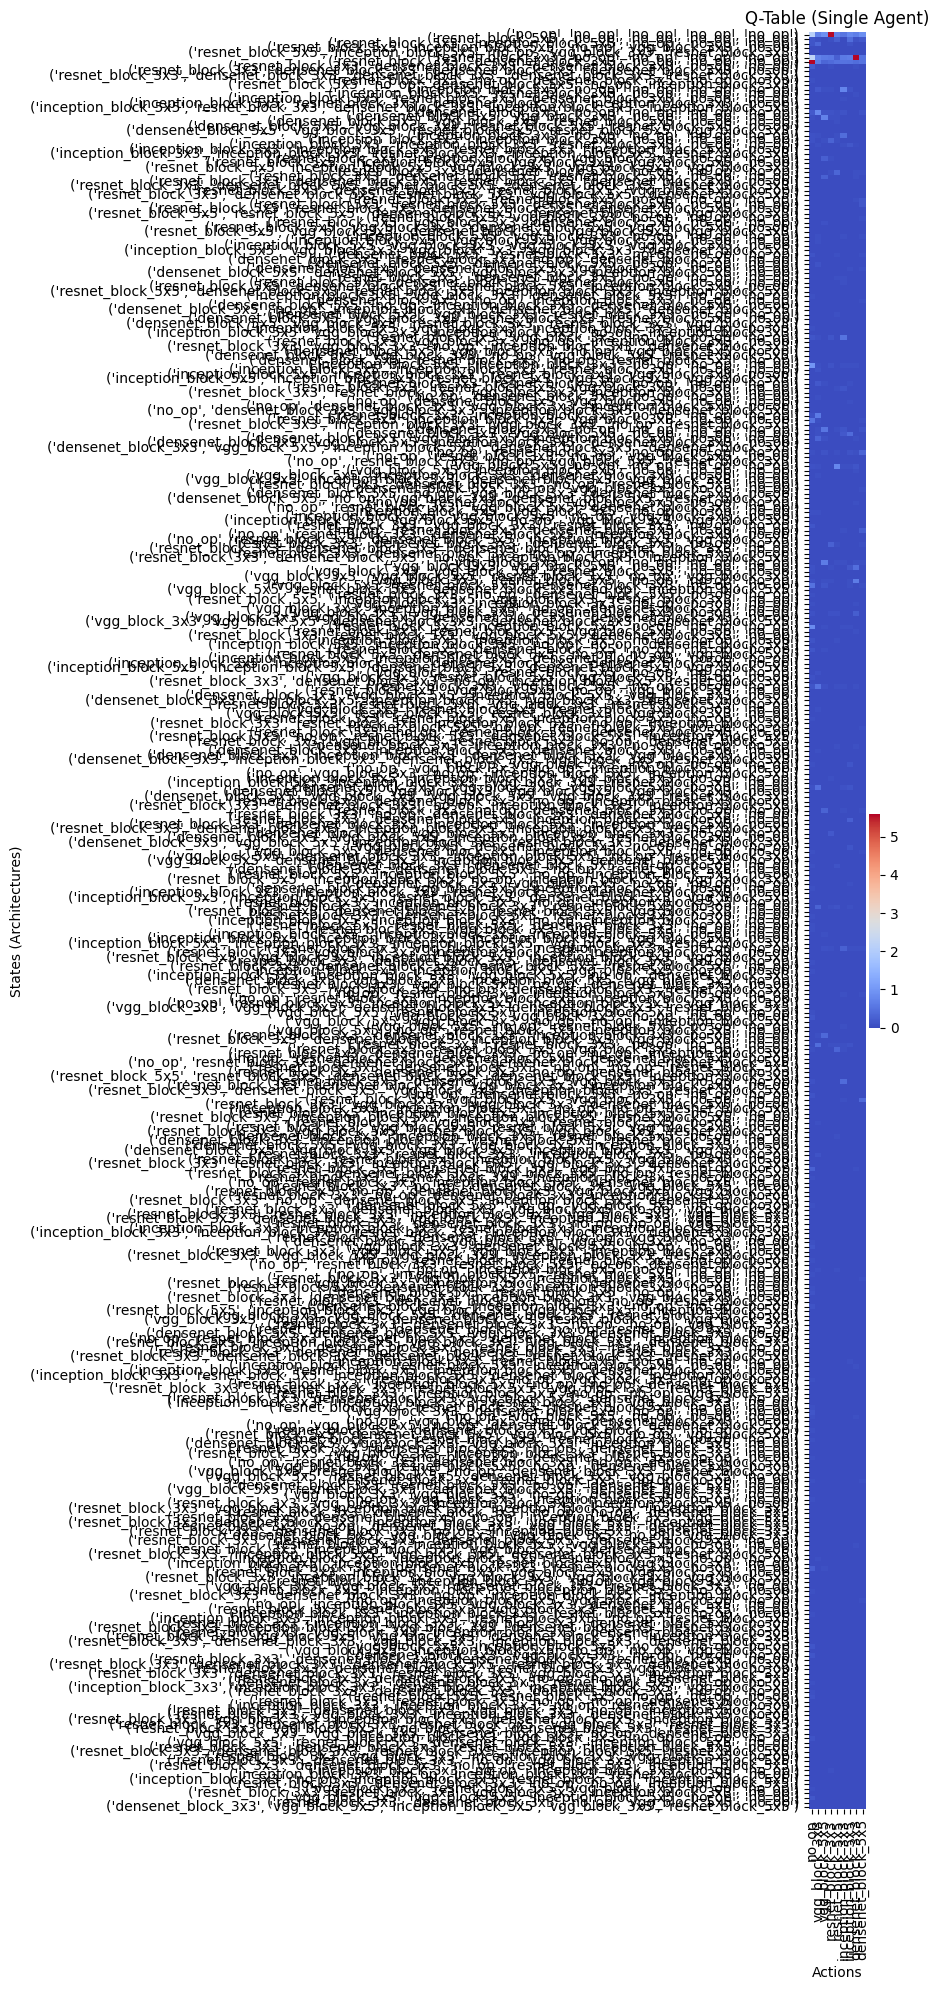

In [11]:
def plot_q_table(q_table, functions):
    states = list(q_table.keys())
    if not states:
        print("No Q-table entries.")
        return
    q_matrix = np.array([q_table[state] for state in states])
    state_labels = [str(state) for state in states]
    plt.figure(figsize=(max(8, len(functions)), min(20, len(states) // 2 + 4)))
    sns.heatmap(q_matrix, annot=False, fmt=".2f", cmap="coolwarm", xticklabels=functions, yticklabels=state_labels)
    plt.title("Q-Table (Single Agent)")
    plt.xlabel("Actions")
    plt.ylabel("States (Architectures)")
    plt.tight_layout()
    plt.show()

plot_q_table(q_table, functions)

In [12]:
best_layers = []
state = tuple(env.reset())
done = False
current_layer = 0

while not done:
    if state not in q_table:
        q_table[state] = np.zeros(len(functions))
    action = np.argmax(q_table[state])
    best_layers.append(action)
    state, reward_acc, done, current_layer = env.step(action)
    state = tuple(state)

print("Best architecture found:")
print(f"Acc: {reward_acc}")
print(f"Layers: {[functions[i] for i in best_layers]}")
print(f"Layers: {best_layers}")

Best architecture found:
Acc: 0.5587999820709229
Layers: ['resnet_block_3x3', 'densenet_block_3x3', 'no_op', 'no_op', 'no_op']
Layers: [3, 7, 0, 0, 0]


In [13]:
layers_selected = [functions[i] for i in best_layers]

In [14]:
# Construct the best CNN model using the selected layers
model = build_cnn(layers_selected, input_shape, num_classes)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=retrain_patience, 
    restore_best_weights=True
)

# Retrain the model
history = model.fit(
    train_data, 
    train_labels, 
    validation_data=(val_data, val_labels), 
    epochs=retrain_epochs, 
    batch_size=batch_size, 
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/200
1250/1250 [==============================] - 13s 9ms/step - loss: 2.4086 - accuracy: 0.5023 - val_loss: 1.1531 - val_accuracy: 0.6052
Epoch 2/200
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9456 - accuracy: 0.6730 - val_loss: 1.2474 - val_accuracy: 0.5707
Epoch 3/200
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7424 - accuracy: 0.7453 - val_loss: 1.1202 - val_accuracy: 0.6300
Epoch 4/200
1250/1250 [==============================] - 11s 9ms/step - loss: 0.5513 - accuracy: 0.8110 - val_loss: 1.1250 - val_accuracy: 0.6562
Epoch 5/200
1250/1250 [==============================] - 11s 9ms/step - loss: 0.3788 - accuracy: 0.8687 - val_loss: 1.3279 - val_accuracy: 0.6471
Epoch 6/200
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2768 - accuracy: 0.9043 - val_loss: 1.5858 - val_accuracy: 0.6386
Epoch 7/200
1250/1250 [==============================] - 11s 9ms/step - loss: 0.1869 - accuracy: 0.9351 - val_loss: 1.8840 -

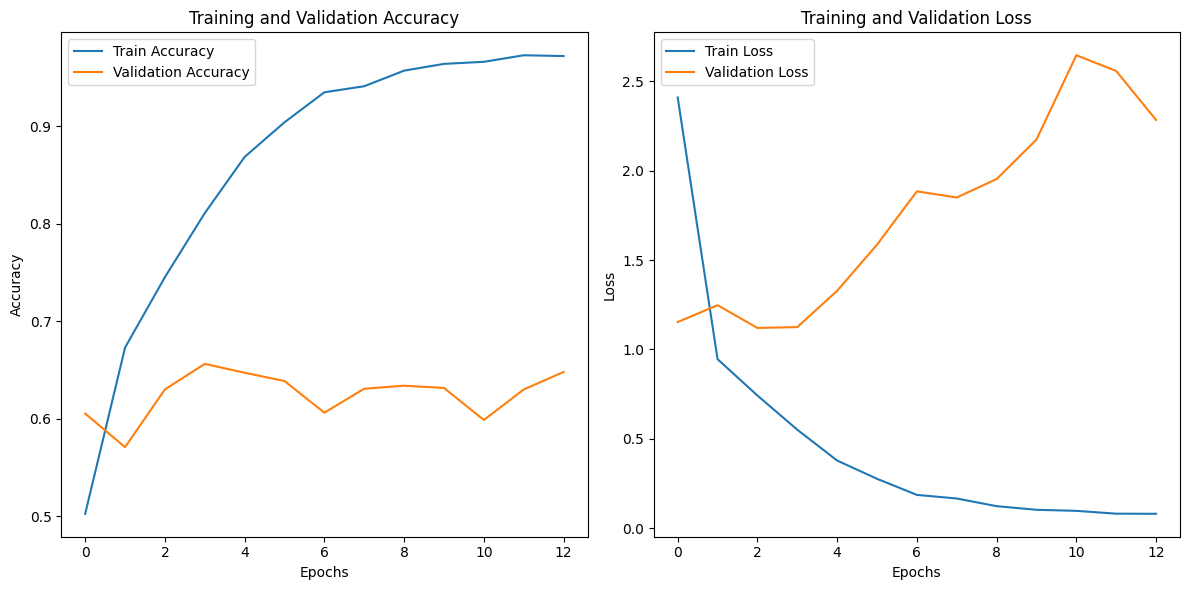

In [15]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [16]:
# Print final results
print("Final Results:")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Final Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"Final Training Loss: {min(history.history['loss']):.4f}")

Final Results:
Best Validation Accuracy: 0.6562
Best Training Accuracy: 0.9731
Final Validation Loss: 1.1202
Final Training Loss: 0.0812


In [17]:
test_loss, test_accuracy = model.evaluate(input_test, label_test, verbose=1)

# Print test results
print("Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.1244 - accuracy: 0.6226
Test Results:
Test Accuracy: 0.6226
Test Loss: 1.1244


313/313 [==============================] - 1s 3ms/step


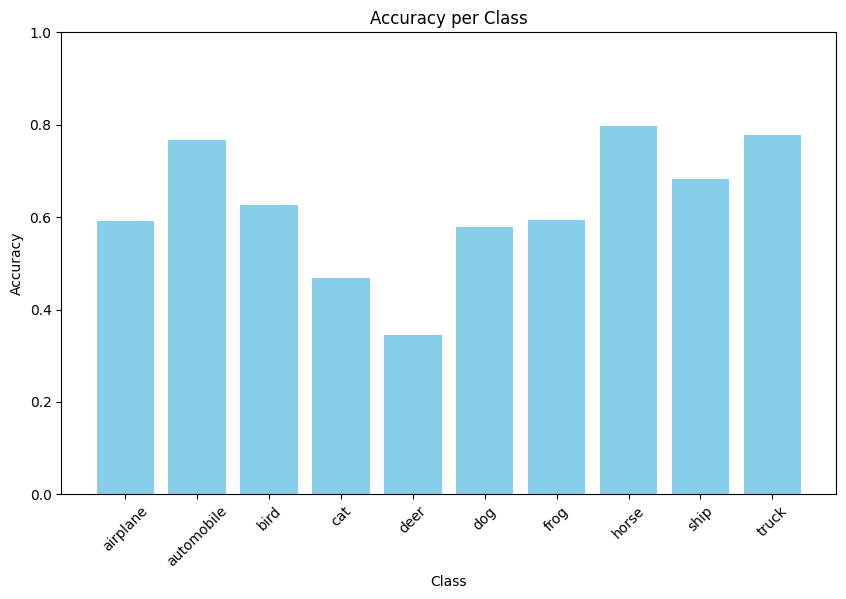

In [18]:
# Get predictions for the test set
predictions = model.predict(input_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(label_test, axis=1)

# Calculate accuracy per class
num_classes = label_test.shape[1]
class_accuracies = []
for class_idx in range(num_classes):
    class_mask = (true_classes == class_idx)
    class_accuracy = np.mean(predicted_classes[class_mask] == true_classes[class_mask])
    class_accuracies.append(class_accuracy)


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Plot the accuracy per class
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.xticks(range(num_classes), class_names, rotation=45)  # Add class names and rotate for better readability
plt.ylim(0, 1)
plt.show()